<a href="https://colab.research.google.com/github/Daybreak365/mischief-check/blob/master/%EC%9C%A0%ED%95%B4%EC%84%B1_%ED%8C%90%EB%8B%A8_%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
%pip install konlpy
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

     |████████████████████████████████| 19.4 MB 1.1 MB/s 
     |████████████████████████████████| 448 kB 56.2 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/Daybreak365/mischief-check/master/labeled_processed.tsv", filename="labeled_processed.tsv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/Daybreak365/mischief-check/master/dev.tsv", filename="dev.tsv")

('dev.tsv', <http.client.HTTPMessage at 0x7f9b70bc26d0>)

In [ ]:
train_data = pd.read_table('labeled_processed.tsv', sep='\t')
test_data = pd.read_table('dev.tsv', sep='\t')

In [ ]:
print('훈련용 리뷰 개수 :',len(train_data))

훈련용 리뷰 개수 : 13167


In [ ]:
train_data[:5]

,comments,contain_gender_bias,bias,hate
0,게임 바둑이 노리터게임,False,none,none
1,죄인이존나ㅋㅋㅋㅋㅋ한남잼민이같아,False,none,hate
2,민주당 잡 것들 또 선동질 특검가자,False,none,hate
3,한남화됨,False,none,hate
4,너 그런게임해,False,none,none


In [ ]:
print('테스트용 리뷰 개수 :',len(test_data))

테스트용 리뷰 개수 : 3548


In [ ]:
test_data[:5]

,comments,contain_gender_bias,bias,hate
0,송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.,False,none,none
1,지현우 나쁜놈,False,none,offensive
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라,False,none,hate
3,설마 ㅈ 현정 작가 아니지??,True,gender,hate
4,이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀...,False,none,offensive


In [ ]:
train_data['comments'].nunique(), train_data['hate'].nunique()

(13107, 2)

In [ ]:
train_data.drop_duplicates(subset=['comments'], inplace=True)

In [ ]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 13107


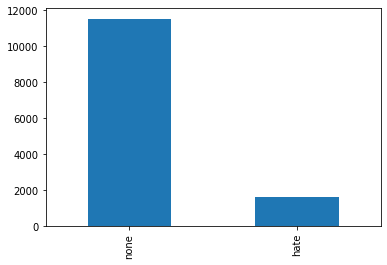

In [ ]:
train_data['hate'].value_counts().plot(kind = 'bar')

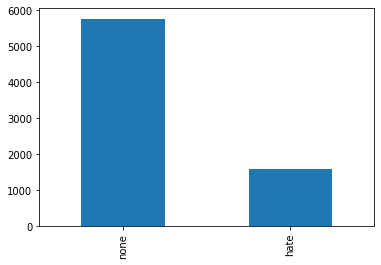

In [ ]:
train_data = train_data.drop(train_data[train_data.hate.eq('none')].sample(frac=.5).index)
train_data['hate'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.groupby('hate').size().reset_index(name = 'count'))

   hate  count
0  hate   1586
1  none   5761


In [ ]:
print(train_data.isnull().values.any())

False


In [ ]:
print(train_data.isnull().sum())

comments               0
contain_gender_bias    0
bias                   0
hate                   0
dtype: int64


In [ ]:
train_data.loc[train_data.comments.isnull()]

,comments,contain_gender_bias,bias,hate


In [ ]:
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().values.any())

False


In [ ]:
print(len(train_data))

7347


In [ ]:
train_data['comments'] = train_data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

,comments,contain_gender_bias,bias,hate
1,죄인이존나ㅋㅋㅋㅋㅋ한남잼민이같아,False,none,hate
2,민주당 잡 것들 또 선동질 특검가자,False,none,hate
3,한남화됨,False,none,hate
4,너 그런게임해,False,none,none
5,능력이 안된다,False,none,hate


In [ ]:
train_data['comments'] = train_data['comments'].str.replace('^ +', "")
train_data['comments'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

comments               0
contain_gender_bias    0
bias                   0
hate                   0
dtype: int64


In [ ]:
train_data.loc[train_data.comments.isnull()][:5]

,comments,contain_gender_bias,bias,hate


In [ ]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

7347


In [ ]:
test_data.drop_duplicates(subset = ['comments'], inplace=True)
test_data['comments'] = test_data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['comments'] = test_data['comments'].str.replace('^ +', "")
test_data['comments'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 3540


In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [ ]:
X_train = []
for sentence in train_data['comments']:
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_train.append(temp_X)

In [ ]:
print(X_train[:3])

[['죄인', '존나', 'ㅋㅋㅋㅋㅋ', '한남', '잼민', '같다'], ['민주당', '잡', '것', '또', '선동', '질', '특검', '가다'], ['한남', '화', '되다']]


In [ ]:
X_test = []
for sentence in test_data['comments']:
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_test.append(temp_X)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

{'우파': 1, '한남': 2, '스': 3, '애니': 4, '게임': 5, '보다': 6, '책': 7, '날씨': 8, '아': 9, '나': 10, '문재인': 11, '민주당': 12, '오늘': 13, '다': 14, '같다': 15, '을': 16, '틀': 17, '진짜': 18, '이다': 19, '좋다': 20, '딱': 21, '아니다': 22, '요': 23, '저': 24, '오징어': 25, '야': 26, '안': 27, '하': 28, '되다': 29, '페미': 30, '있다': 31, '네': 32, '노엘': 33, '개': 34, '없다': 35, '나오다': 36, '내': 37, '오다': 38, '님': 39, '뭐': 40, '로': 41, '만': 42, '읽다': 43, '너무': 44, '왜': 45, '거': 46, '그': 47, '보고': 48, '중': 49, '박근혜': 50, 'ㅋㅋ': 51, '들다': 52, 'ㅅㅂ': 53, '어': 54, '취미': 55, '좌파': 56, '일베': 57, '가다': 58, '에서': 59, '새끼': 60, '고': 61, '더힐': 62, '그렇다': 63, '화': 64, '라': 65, '못': 66, '게': 67, '시발': 68, '니': 69, '미치다': 70, '유충': 71, '잇다': 72, '알다': 73, '랑': 74, '재밌다': 75, '자다': 76, '나다': 77, '사람': 78, '날': 79, '존나': 80, '임': 81, '지': 82, '이야': 83, '인': 84, '지금': 85, 'ㅠ': 86, '해주다': 87, '추천': 88, '딱이다': 89, '더': 90, '씨발': 91, '근데': 92, '분': 93, '싶다': 94, '너': 95, '먹다': 96, '또': 97, '헐다': 98, '당': 99, '무슨': 100, '인데': 101, '하고': 102, '좋아하다': 103, '어떻

In [ ]:
import json
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 7068
등장 빈도가 2번 이하인 희귀 단어의 수: 5240
단어 집합에서 희귀 단어의 비율: 74.13695529145444
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 16.262526610935147


In [ ]:
vocab_size = 35000
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 35000


In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
mapping = {'hate': 0, 'offensive': 0, 'none': 1}
y_train = np.array(list(map(lambda x: mapping[x], train_data['hate'])))
y_test = np.array(list(map(lambda x: mapping[x], test_data['hate'])))

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

7346
7346


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 15
리뷰의 평균 길이 : 5.243397767492513


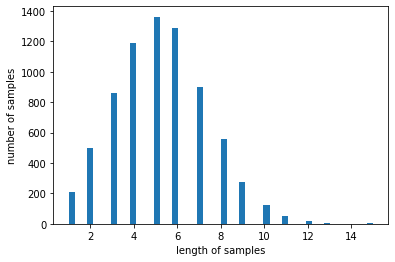

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 100.0


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=5, validation_split=0.2)

Epoch 1/15
1176/1176 [==============================] - 119s 91ms/step - loss: 0.3530 - acc: 0.8696 - val_loss: 0.3466 - val_acc: 0.8585

Epoch 00001: val_acc improved from -inf to 0.85850, saving model to best_model.h5
Epoch 2/15
1176/1176 [==============================] - 105s 89ms/step - loss: 0.2782 - acc: 0.9016 - val_loss: 0.3848 - val_acc: 0.8653

Epoch 00002: val_acc improved from 0.85850 to 0.86531, saving model to best_model.h5
Epoch 3/15
1176/1176 [==============================] - 104s 88ms/step - loss: 0.2505 - acc: 0.9086 - val_loss: 0.3004 - val_acc: 0.8626

Epoch 00003: val_acc did not improve from 0.86531
Epoch 4/15
1176/1176 [==============================] - 103s 88ms/step - loss: 0.2144 - acc: 0.9192 - val_loss: 0.5095 - val_acc: 0.8190

Epoch 00004: val_acc did not improve from 0.86531
Epoch 5/15
1176/1176 [==============================] - 103s 88ms/step - loss: 0.2028 - acc: 0.9244 - val_loss: 0.4585 - val_acc: 0.8054

Epoch 00005: val_acc did not improve from 0

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

111/111 [==============================] - 5s 29ms/step - loss: 0.4146 - acc: 0.8472

 테스트 정확도: 0.8472


In [ ]:
loaded_model.save('my_model.h5')

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)
  score = float(loaded_model.predict(pad_new))
  return score

In [ ]:
sentiment_predict('개새끼')

0.8730605244636536

In [ ]:
from bs4 import BeautifulSoup
import requests
import re

USER_AGENT = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) ''Chrome/74.0.3729.169 Safari/537.36 '}

def count_mischief(url, criterion):
    count = 0
    mischiefes = []
    soup = BeautifulSoup(requests.get(url, headers=USER_AGENT).content, 'html.parser')
    for tag in soup.find_all(['span', 'p', 'h', 'div', 'a'], recursive=True):
        try:
            for _ in tag.findChildren(recursive=False):
                raise Exception()
        except Exception:
            continue
        text = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", tag.get_text())
        if text:
          if (1 - sentiment_predict(text)) >= criterion:
            mischiefes.append(text)
            count += 1
    print(mischiefes)
    return count

In [ ]:
count_mischief('https://gall.dcinside.com/mgallery/board/view/?id=itall&no=116908', .75)

['뭐냐 씨발']


1